In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [2]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [ ]:
train_dir = './Split_Data/train'
val_dir = './Split_Data/val'
test_dir = './Split_Data/test'

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed: int):
    random.seed(seed)                # Python random seed
    np.random.seed(seed)             # NumPy random seed
    torch.manual_seed(seed)          # PyTorch CPU seed
    torch.cuda.manual_seed(seed)     # PyTorch GPU seed (for single GPU)
    torch.cuda.manual_seed_all(seed) # PyTorch GPU seed (for multi-GPU)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disable auto-tuning for reproducibility

set_seed(42)

In [5]:
# Device Configuration
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Data Transformations
transform = {
    'train': transforms.Compose([
        #transforms.Resize((32, 32)),
        transforms.Resize((64, 64)),  # Resize images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        #transforms.Resize((32, 32)),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        #transforms.Resize((32, 32)),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# Load Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])

Using device: cuda


In [6]:
# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

In [7]:
import torch

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_path='model/best_model.pth'):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0  # Keep track of the best validation accuracy

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        val_loss = 0
        val_correct = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the model if the validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model with Val Acc: {best_val_acc:.4f}")

    return history


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, class_names):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()

    test_acc = test_correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    
class_names = test_dataset.classes  # Subfolder names as class names

In [9]:
import torch
from sklearn.metrics import f1_score

def calculate_f1_score(model, test_loader, class_names, average=None):
    """
    Calculate the F1 score for each class in a classification model.

    Parameters:
        model: PyTorch model to evaluate.
        test_loader: DataLoader for the test dataset.
        average: The type of averaging performed on the data:
                 'macro', 'micro', 'weighted', or None.

    Returns:
        f1_per_class: A list of F1 scores for each class if average=None.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1 score for each class
    f1_per_class = f1_score(all_labels, all_preds, average=average)

    if average is None:
        print("F1 Score per class:")
        for i, score in enumerate(f1_per_class):
            print(f"{class_names[i]}: {score:.4f}")
    else:
        print(f"F1 Score ({average}): {f1_per_class:.4f}")
    
    return f1_per_class


In [35]:
import torch
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_with_metrics(model, test_loader, class_names):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    test_correct = 0

    # Collect predictions, true labels, and calculate accuracy
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_correct += (preds == labels).sum().item()

    # Test Accuracy
    test_acc = test_correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # F1 Score per class
    f1_scores = f1_score(all_labels, all_preds, average=None)
    print("F1 Scores per class:")
    for i, score in enumerate(f1_scores):
        print(f"{class_names[i]}: {score:.4f}")

    return #test_acc, cm, f1_scores


In [10]:
def plot_misclassified_images(model, test_loader, class_names, num_images=10, n_cols=5, mean=None, std=None):
    import torch
    import matplotlib.pyplot as plt
    import math
    import numpy as np

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    # Identify misclassified samples
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            for input_image, pred, label in zip(inputs, preds, labels):
                if pred != label:
                    misclassified_images.append(input_image.cpu())
                    misclassified_preds.append(pred.cpu())
                    misclassified_labels.append(label.cpu())
                if len(misclassified_images) >= num_images:
                    break
            if len(misclassified_images) >= num_images:
                break

    # Calculate grid dimensions
    n_rows = math.ceil(num_images / n_cols)

    # Denormalization function
    def denormalize(image, mean, std):
        if mean is not None and std is not None:
            mean = np.array(mean).reshape(1, 1, -1)
            std = np.array(std).reshape(1, 1, -1)
            image = (image * std) + mean
        return np.clip(image, 0, 1)

    # Plot misclassified images in a grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(misclassified_images):
            image = misclassified_images[i].permute(1, 2, 0).numpy()
            if mean and std:
                image = denormalize(image, mean, std)
            ax.imshow(image)
            ax.set_title(f"Pred: {class_names[misclassified_preds[i]]}\nActual: {class_names[misclassified_labels[i]]}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
def predict_and_plot_multiple_images(model, image_paths, true_class, class_names, device):
    """
    Predicts and plots results for multiple images, showing true and predicted classes.
    
    Args:
        model: The trained PyTorch model.
        image_paths: List of paths to the images.
        true_class: The true class label (string) for all images (assuming same class).
        class_names: List of all class names.
        device: The device to use (CPU or GPU).
    """
    # Define the transformations for the images
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to match model input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize a figure for plotting
    fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))
    
    # Loop through each image path
    for idx, image_path in enumerate(image_paths):
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device
        
        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_names[predicted.item()]
        
        # Denormalize the image for plotting
        image_np = np.array(image) / 255.0  # Convert to [0, 1] range for visualization
        
        # Plot the image with true and predicted labels
        axs[idx].imshow(image_np)
        axs[idx].set_title(f"True: {true_class[idx]}\nPredicted: {predicted_class}")
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
set_seed(42)
batch_size = 1255

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Classes
classes = train_dataset.classes
num_classes = len(classes)

# Get one batch from the train_loader
for sequences, labels in train_loader:
    print(f"Sequence batch shape: {sequences.shape}")  # Shape of the batch
    print(f"Label batch shape: {labels.shape}")        # Shape of the labels
    break  # Exit after printing one batch


Sequence batch shape: torch.Size([1255, 3, 64, 64])
Label batch shape: torch.Size([1255])


complicated CBAM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.max_pool = nn.AdaptiveMaxPool2d(1)  # Global Max Pooling

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3,7), 'Kernel size must be 3 or 7'
        padding = 3 if kernel_size ==7 else 1

        self.conv1 = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        avg_out = torch.mean(x,dim=1,keepdim=True)
        max_out,_ = torch.max(x,dim=1,keepdim=True)
        x = torch.cat([avg_out,max_out],dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# Define the CBAM Module
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM,self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    def forward(self,x):
        x_out = x * self.channel_attention(x)
        x_out = x_out * self.spatial_attention(x_out)
        return x_out

# Define the CNN with CBAM for Traffic Sign Classification
class CNN_CBAM(nn.Module):
    def __init__(self, num_classes=43):  
        super(CNN_CBAM, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            CBAM(64),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            CBAM(128),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            CBAM(256),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.dropout = nn.Dropout(0.3)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self,x):
        x = self.layer1(x)  # Output size reduction
        x = self.layer2(x)  # Output size reduction
        x = self.layer3(x)  # Output size reduction
        x = self.layer4(x)  # Output size reduction
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


Epoch 1/30: Train Loss: 0.8397, Train Acc: 0.7156, Val Loss: 1.3837, Val Acc: 0.5308
Saved best model with Val Acc: 0.5308
Epoch 2/30: Train Loss: 0.2039, Train Acc: 0.9332, Val Loss: 0.3505, Val Acc: 0.8855
Saved best model with Val Acc: 0.8855
Epoch 3/30: Train Loss: 0.0861, Train Acc: 0.9741, Val Loss: 0.2321, Val Acc: 0.9242
Saved best model with Val Acc: 0.9242
Epoch 4/30: Train Loss: 0.0371, Train Acc: 0.9891, Val Loss: 0.3652, Val Acc: 0.8973
Epoch 5/30: Train Loss: 0.0750, Train Acc: 0.9784, Val Loss: 0.3538, Val Acc: 0.8942
Epoch 6/30: Train Loss: 0.0183, Train Acc: 0.9957, Val Loss: 0.3114, Val Acc: 0.9013
Epoch 7/30: Train Loss: 0.0184, Train Acc: 0.9948, Val Loss: 0.3092, Val Acc: 0.8878
Epoch 8/30: Train Loss: 0.0063, Train Acc: 0.9991, Val Loss: 0.1949, Val Acc: 0.9415
Saved best model with Val Acc: 0.9415
Epoch 9/30: Train Loss: 0.0145, Train Acc: 0.9954, Val Loss: 0.1051, Val Acc: 0.9645
Saved best model with Val Acc: 0.9645
Epoch 10/30: Train Loss: 0.0066, Train Acc: 0

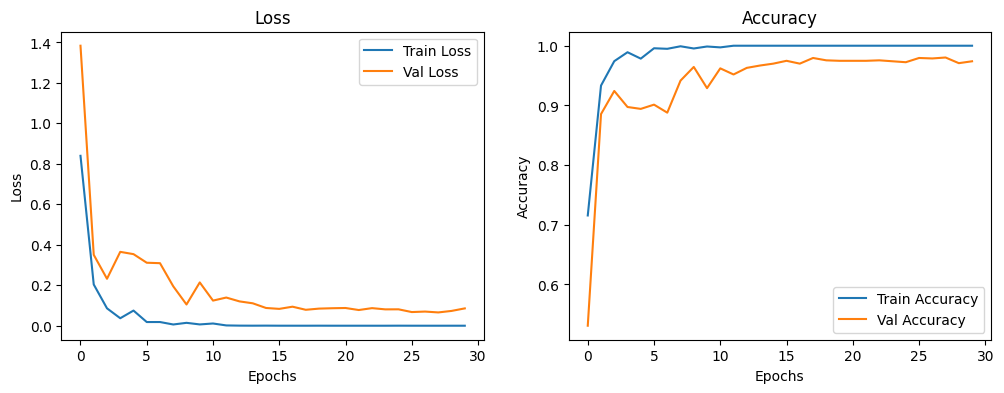

In [ ]:
set_seed(42)
# Initialize the model architecture
model = CNN_CBAM(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the Model
epochs = 30
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, save_path='./model/cbamo_5.pth')

plot_history(history)

In [ ]:

image_paths = [
    "./Split_Data/test/pedestrian/uae_aug_0.png",
    "./Split_Data/test/road_work/cze971.png",
    "./Split_Data/train/yield/aug_australia_1.png",
    "./Split_Data/train/animal_crossing/00031_00009_00025.png"
]
true_class = ["pedestiran", "road_work", "yield", "animal_crossing" ]  # Replace with the correct true class name

image_paths_stop = [
    "./Split_Data/test/stop/malaysia.png",
    "./Split_Data/test/stop/japan.png",
    "./Split_Data/test/stop/unitedarabemirates.png",
    "./Split_Data/test/stop/thailand.png",
    "./Split_Data/test/stop/taiwan.png",
    "./Split_Data/test/stop/canada.png"
]
true_class_stop = ["stop"]*6  

In [42]:
model = CNN_CBAM(num_classes=num_classes).to(device)
model_path = 'C:/Users/weike/Downloads/aps360/model/cbamo_5.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_path}")

Model loaded from C:/Users/weike/Downloads/aps360/model/cbamo_5.pth


Test Accuracy: 0.9538


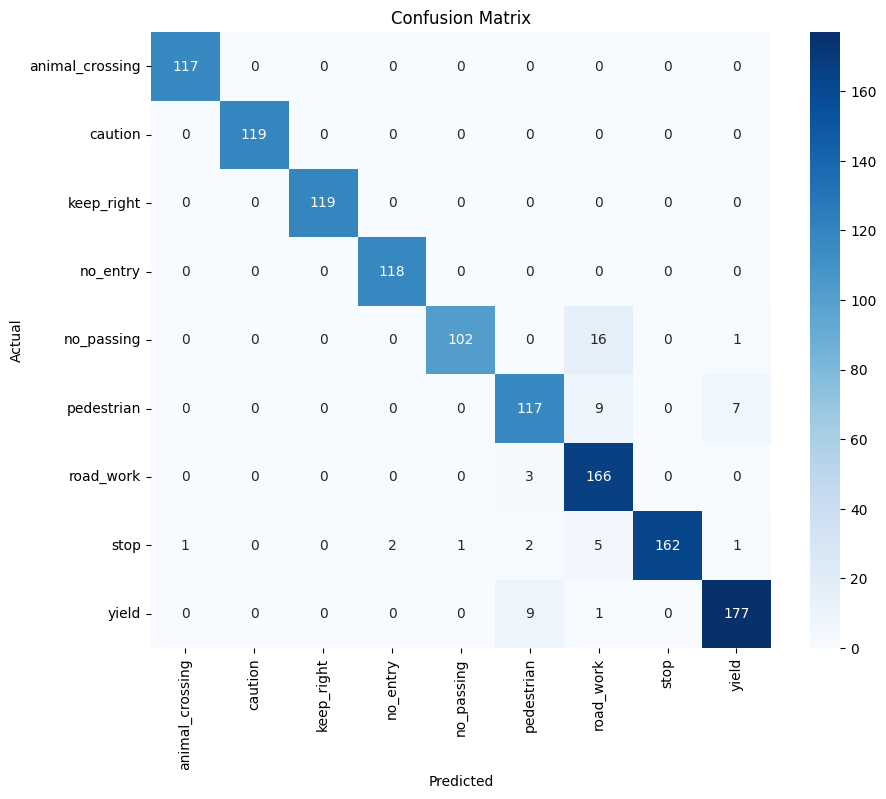

F1 Scores per class:
animal_crossing: 0.9957
caution: 1.0000
keep_right: 1.0000
no_entry: 0.9916
no_passing: 0.9189
pedestrian: 0.8864
road_work: 0.9071
stop: 0.9643
yield: 0.9491


In [67]:
evaluate_model_with_metrics(model, test_loader, class_names)

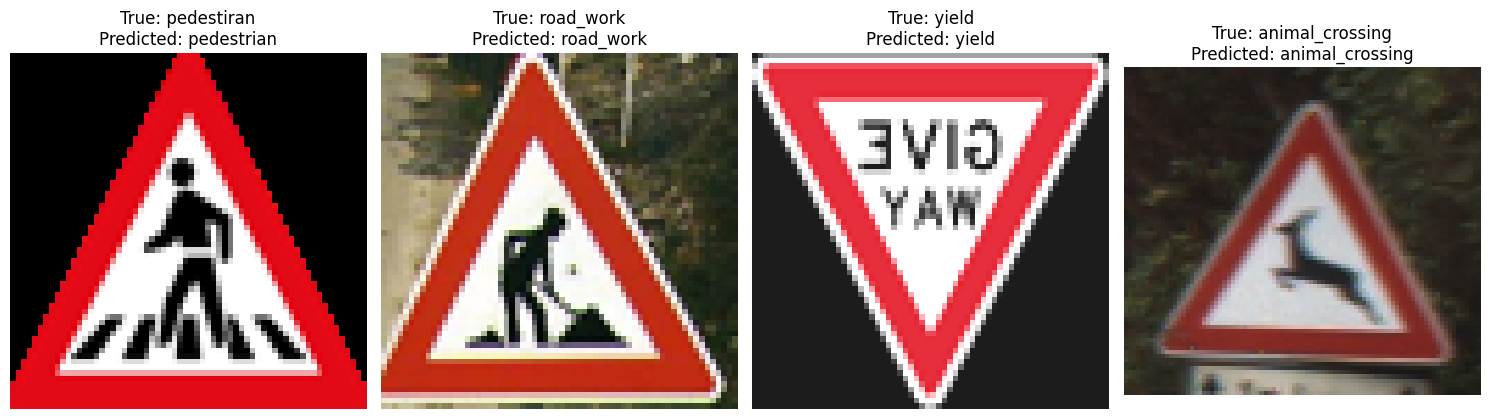

In [68]:
##Can the model handle similar images across different classes?
predict_and_plot_multiple_images(model, image_paths, true_class, class_names, device)

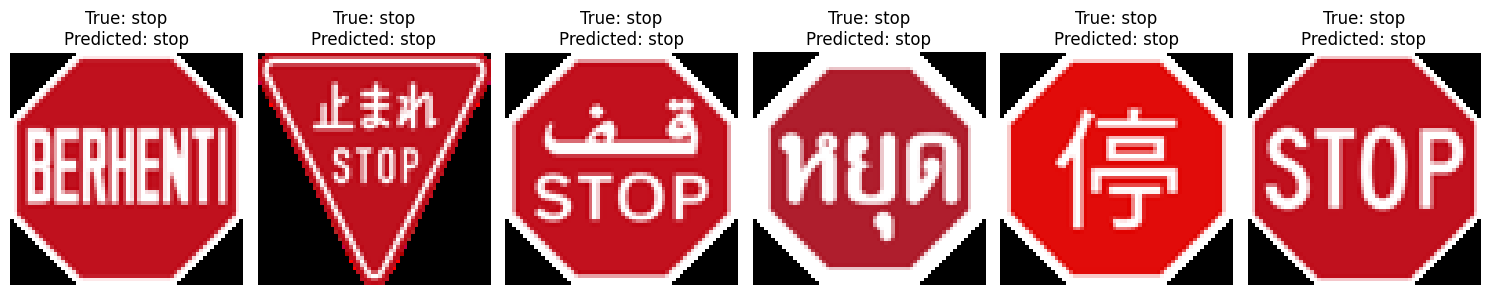

In [69]:
#Can the model generalize within the same class for different appearances?
predict_and_plot_multiple_images(model, image_paths_stop, true_class_stop, class_names, device)

In [14]:
import os
import random
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Function to evaluate the model and return predictions
def evaluate_and_plot(model, dataloader, class_names):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    # Collect random images for each class
    random_images = {cls: None for cls in class_names}
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Pick random images from each class
            for i in range(len(labels)):
                label = labels[i].item()
                cls_name = class_names[label]
                if random_images[cls_name] is None:
                    random_images[cls_name] = (images[i].cpu(), predicted[i].item())
    
    # Calculate accuracy
    accuracy = correct / total * 100
    print(f'Accuracy: {accuracy:.2f}%')
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.show()
    
    # Plot random images from each class
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))
    for idx, cls_name in enumerate(class_names):
        img, pred_class = random_images[cls_name]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)
        
        axs[idx].imshow(img)
        axs[idx].set_title(f"True: {cls_name}\nPred: {class_names[pred_class]}")
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

Model loaded from C:/Users/weike/Downloads/aps360/model/cbamo_5.pth
Accuracy: 95.06%


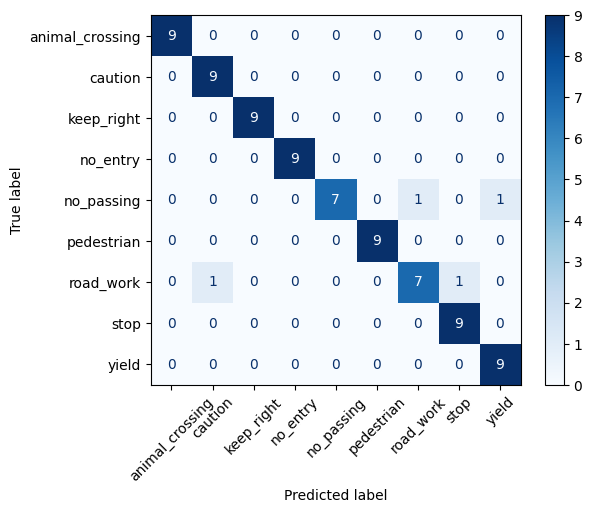

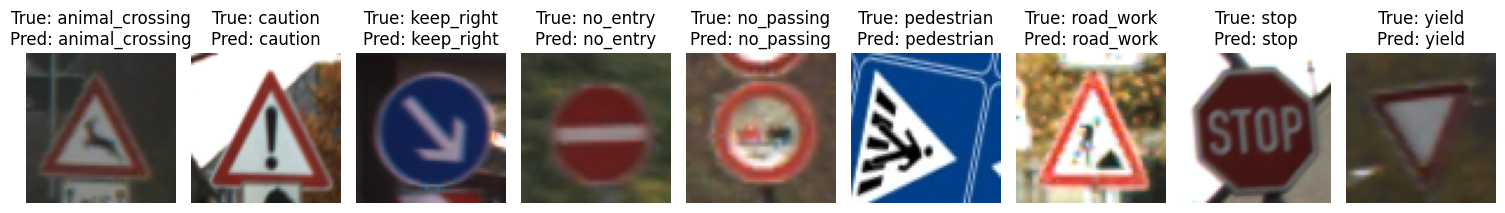

In [44]:
unseen_dir = 'C:/Users/weike/Downloads/aps360/UnseenData'
set_seed(42)

# Load the dataset
dataset = ImageFolder(unseen_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

# Get class names
class_names = dataset.classes

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_CBAM(num_classes=len(class_names)).to(device)
model_path = 'C:/Users/weike/Downloads/aps360/model/cbamo_5.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
print(f"Model loaded from {model_path}")

# Call the function
evaluate_and_plot(model, dataloader, class_names)

In [ ]:
set_seed(42)

model = CNN_CBAM(num_classes=num_classes).to(device)
model_path = 'C:/Users/weike/Downloads/aps360/model/cbamo_5.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_path}")
plot_misclassified_images(model, test_loader, class_names=class_names, num_images=50, n_cols= 5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Epoch 1/40: Train Loss: 0.8992, Train Acc: 0.7032, Val Loss: 1.9006, Val Acc: 0.3167
Saved best model with Val Acc: 0.3167
Epoch 2/40: Train Loss: 0.2430, Train Acc: 0.9199, Val Loss: 0.4121, Val Acc: 0.8476
Saved best model with Val Acc: 0.8476
Epoch 3/40: Train Loss: 0.1041, Train Acc: 0.9697, Val Loss: 0.1732, Val Acc: 0.9558
Saved best model with Val Acc: 0.9558
Epoch 4/40: Train Loss: 0.0545, Train Acc: 0.9837, Val Loss: 0.6385, Val Acc: 0.7788
Epoch 5/40: Train Loss: 0.0369, Train Acc: 0.9906, Val Loss: 0.2932, Val Acc: 0.8894
Epoch 6/40: Train Loss: 0.0282, Train Acc: 0.9937, Val Loss: 0.3371, Val Acc: 0.8855
Epoch 7/40: Train Loss: 0.0125, Train Acc: 0.9970, Val Loss: 0.3101, Val Acc: 0.9115
Epoch 8/40: Train Loss: 0.0075, Train Acc: 0.9987, Val Loss: 0.3768, Val Acc: 0.8878
Epoch 9/40: Train Loss: 0.0205, Train Acc: 0.9939, Val Loss: 0.4629, Val Acc: 0.8728
Epoch 10/40: Train Loss: 0.0173, Train Acc: 0.9946, Val Loss: 0.2666, Val Acc: 0.9005
Epoch 11/40: Train Loss: 0.0246, Tr

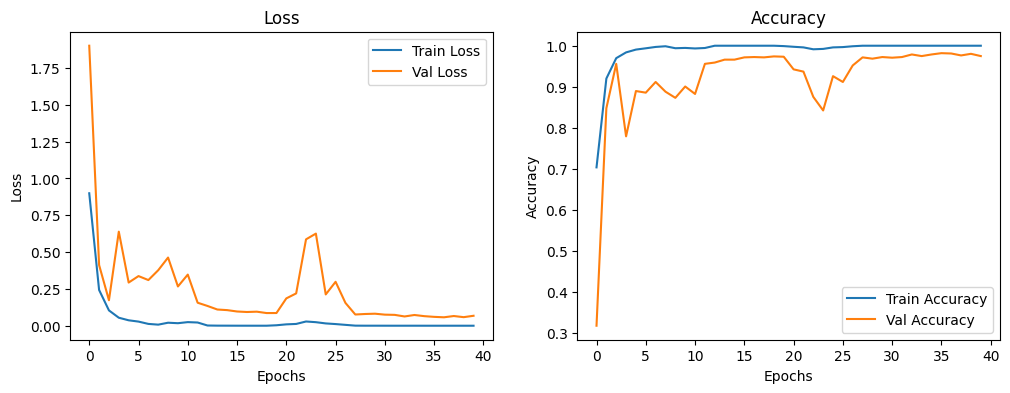

In [27]:
set_seed(42)
# Initialize the model architecture
model = CNN_CBAM(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00085, weight_decay=1e-4)

# Train the Model
epochs = 40
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, save_path='C:/Users/weike/Downloads/aps360/model/cbamo_5.pth')

plot_history(history)

Model loaded from C:/Users/weike/Downloads/aps360/model/cbamo_5.pth
Test Accuracy: 0.9538


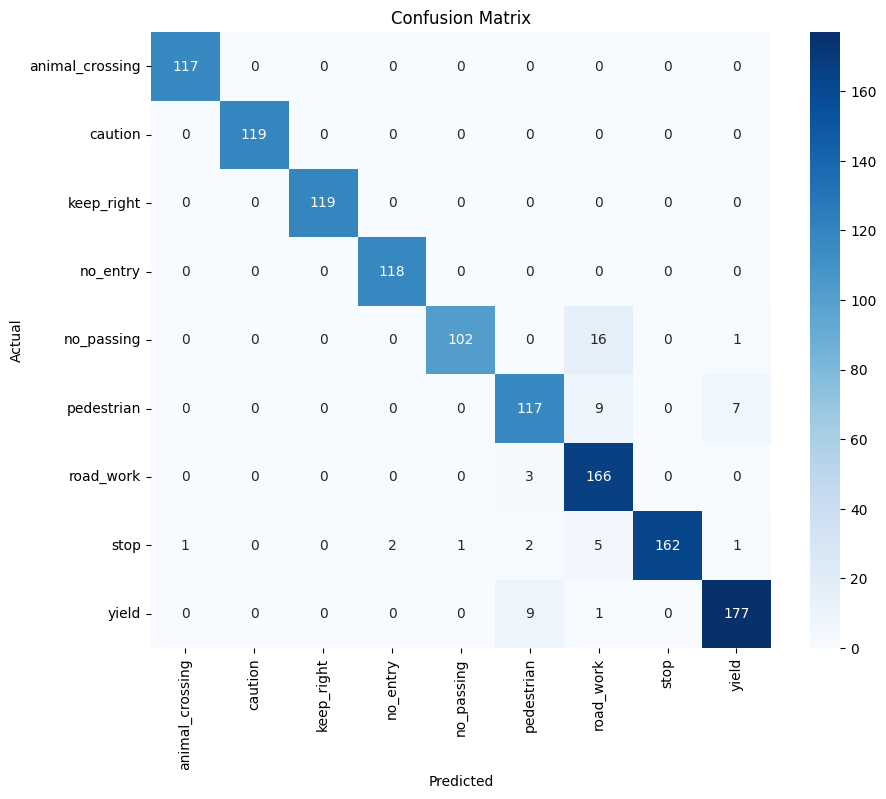

In [ ]:
set_seed(42)
# Load the saved state dictionary
model = CNN_CBAM(num_classes=num_classes).to(device)
model_path = './model/cbamo_5.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_path}")
evaluate_model(model, test_loader)
plot_confusion_matrix(model, test_loader, class_names)

Model loaded from C:/Users/weike/Downloads/aps360/model/cbamo_5.pth


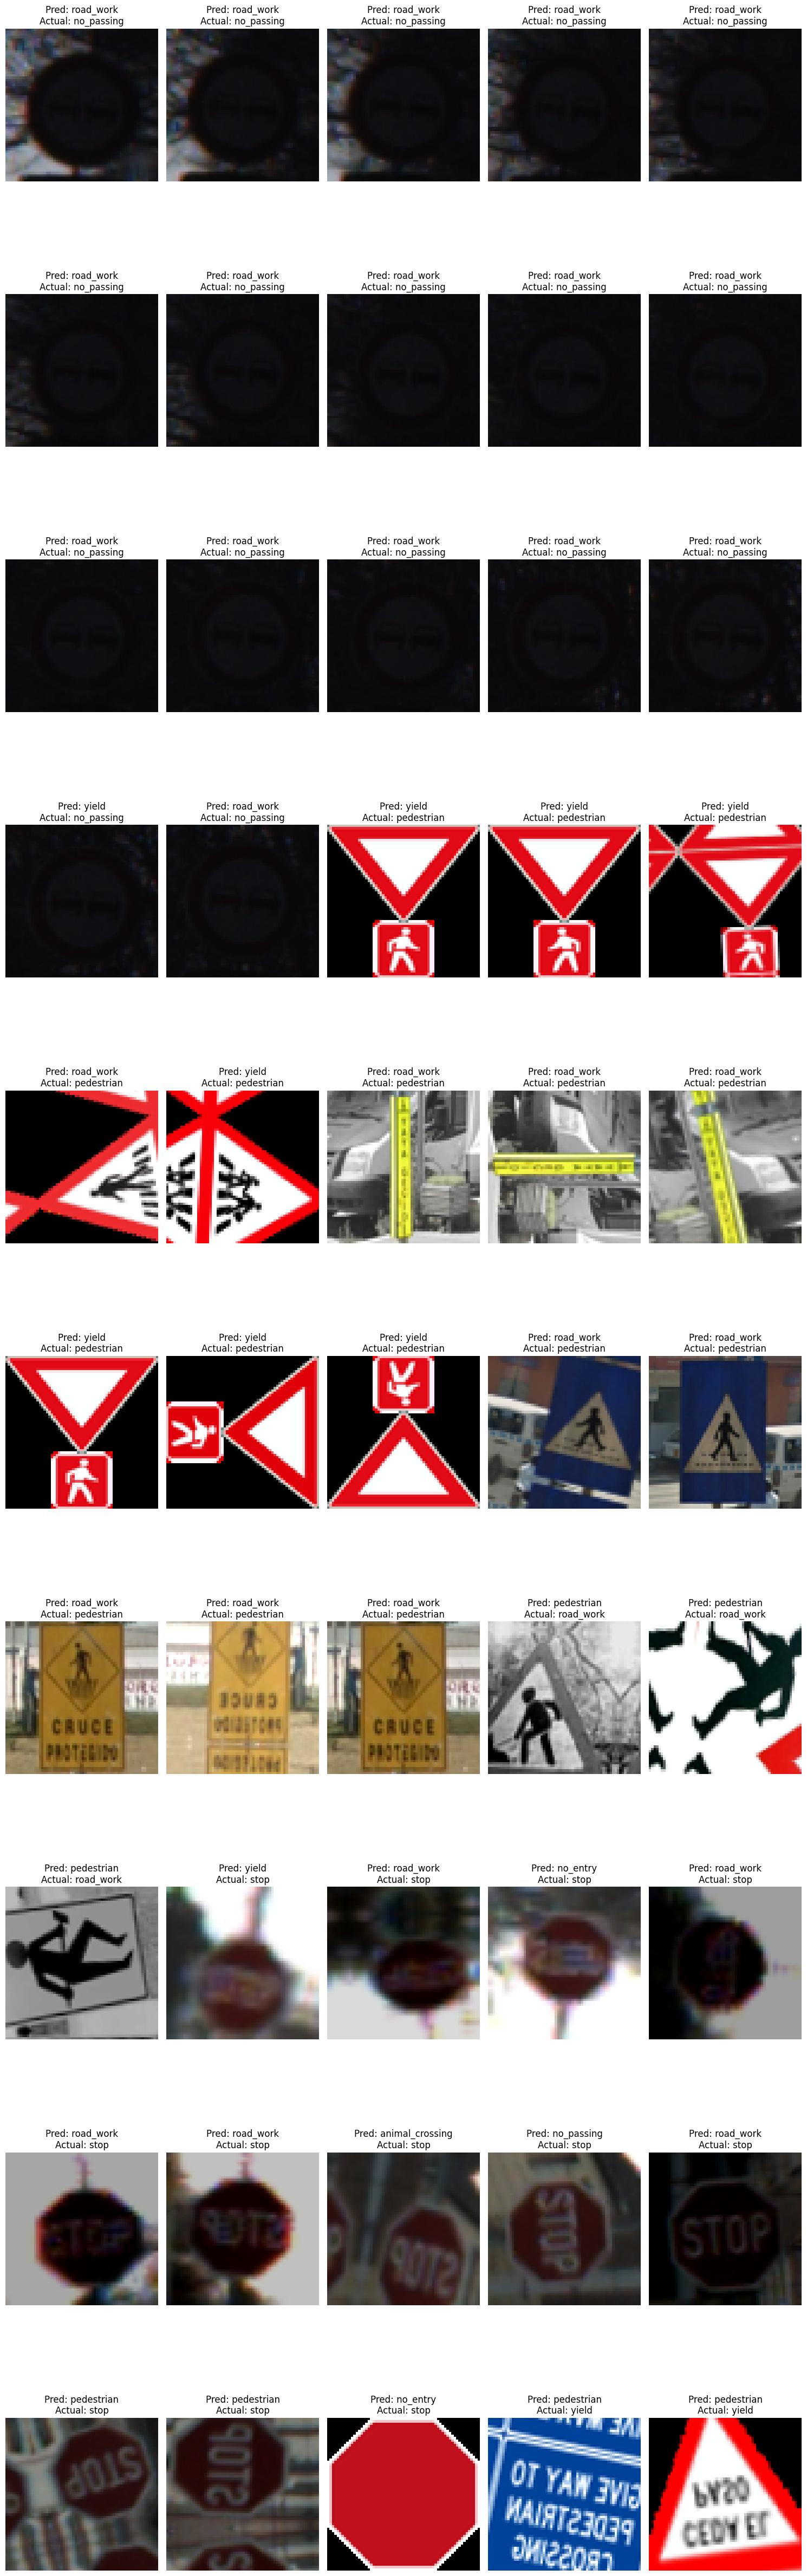

In [ ]:
set_seed(42)

model = CNN_CBAM(num_classes=num_classes).to(device)
model_path = './model/cbamo_5.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_path}")
plot_misclassified_images(model, test_loader, class_names=class_names, num_images=50, n_cols= 5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Baseline

In [13]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=64*64*3, hidden_size=150, num_classes=10):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP().to(device)

Epoch 1/30: Train Loss: 1.8581, Train Acc: 0.4402, Val Loss: 1.7057, Val Acc: 0.4961
Saved best model with Val Acc: 0.4961
Epoch 2/30: Train Loss: 1.4258, Train Acc: 0.6689, Val Loss: 1.4684, Val Acc: 0.6177
Saved best model with Val Acc: 0.6177
Epoch 3/30: Train Loss: 1.1855, Train Acc: 0.7394, Val Loss: 1.2929, Val Acc: 0.6864
Saved best model with Val Acc: 0.6864
Epoch 4/30: Train Loss: 1.0320, Train Acc: 0.7803, Val Loss: 1.1617, Val Acc: 0.6983
Saved best model with Val Acc: 0.6983
Epoch 5/30: Train Loss: 0.9218, Train Acc: 0.8073, Val Loss: 1.0852, Val Acc: 0.7370
Saved best model with Val Acc: 0.7370
Epoch 6/30: Train Loss: 0.8393, Train Acc: 0.8300, Val Loss: 1.0264, Val Acc: 0.7457
Saved best model with Val Acc: 0.7457
Epoch 7/30: Train Loss: 0.7743, Train Acc: 0.8409, Val Loss: 0.9620, Val Acc: 0.7591
Saved best model with Val Acc: 0.7591
Epoch 8/30: Train Loss: 0.7200, Train Acc: 0.8554, Val Loss: 0.9098, Val Acc: 0.7678
Saved best model with Val Acc: 0.7678
Epoch 9/30: Trai

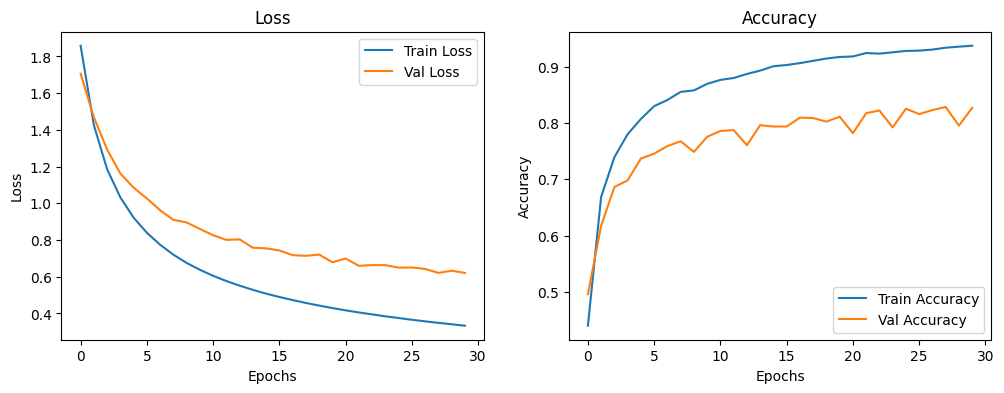

In [ ]:
set_seed(42)
model = MLP(num_classes=num_classes).to(device)
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the Model
epochs = 30
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, save_path='./model/baseline.pth')
plot_history(history)

Model loaded from C:/Users/weike/Downloads/aps360/model/baseline.pth
Test Accuracy: 0.7777


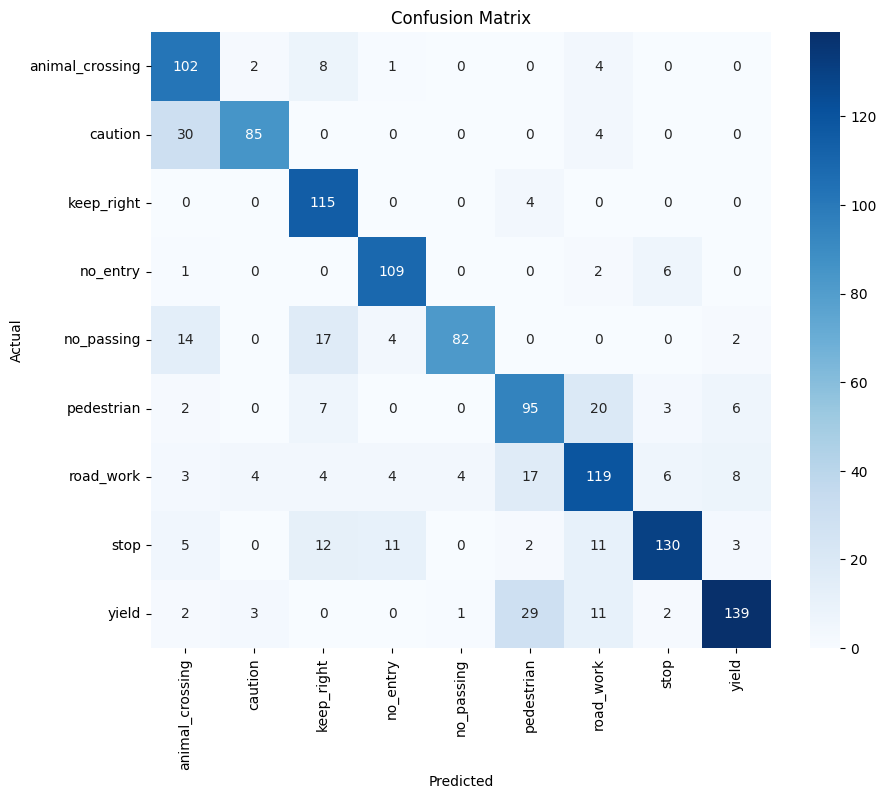

In [ ]:
set_seed(42)
# Initialize the model architecture
model = MLP(num_classes=num_classes).to(device)

# Load the saved state dictionary
model_path = './model/baseline.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_path}")
evaluate_model(model, test_loader)
plot_confusion_matrix(model, test_loader, class_names)